## Data Cleaning Stage

### Data reading

This notebook brings uses the scripts read_data_features.py and read_data_genre_track.py to arrive at a cleaned dataset with ready to use features and labels.

The following is 'read_data_genre_track.py'. 

In [1]:
import numpy as np
import pandas as pd

In [2]:
# import xgboost as xgb
import itertools
import pickle
import matplotlib
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle

#matplotlib.rcParams.update({'font.size': 14})
%matplotlib inline

In [3]:
metadata_path = 'fma_metadata'

In [4]:
## Read genre information
genres = pd.read_csv(metadata_path+'\\genres.csv')

In [5]:
genre_grps = genres.groupby('parent')


In [6]:
genre_id_root = genre_grps.get_group(0)['genre_id'] # Extract the parent groups
genre_id_name = genre_grps.get_group(0)['title']
main_label_dict = dict(zip(list(genre_id_root),list(genre_id_name)))

In [7]:
main_label_dict

{2: 'International',
 3: 'Blues',
 4: 'Jazz',
 5: 'Classical',
 8: 'Old-Time / Historic',
 9: 'Country',
 10: 'Pop',
 12: 'Rock',
 13: 'Easy Listening',
 14: 'Soul-RnB',
 15: 'Electronic',
 17: 'Folk',
 20: 'Spoken',
 21: 'Hip-Hop',
 38: 'Experimental',
 1235: 'Instrumental'}

In [8]:
## Read track information
fields = ['track']
tracks = pd.read_csv(metadata_path+'\\tracks_mod.csv',nrows=85000)
tracks.head()

,track_id,genres,genres_all
0,2,[21],[21]
1,3,[21],[21]
2,5,[21],[21]
3,10,[10],[10]
4,20,"[76, 103]","[17, 10, 76, 103]"


In [9]:
tracks = tracks.dropna()

In [10]:
tgen = list(tracks['genres'])
#print(tgen)

In [11]:
tgen = [t.replace('[','') for t in tgen]
tgen = [t.replace(']','') for t in tgen]
tgen = [t.replace(' ','') for t in tgen]
#print(tgen)

In [12]:
for k in range(len(tgen)):
    if(len(tgen[k])!=0):
        tgen[k] = [i for i in map(int, tgen[k].split(','))]
    else:
        tgen[k]=[]
#print(tgen)

In [13]:
tracks['genres']=tgen

In [14]:
tracks.head()

,track_id,genres,genres_all
0,2,[21],[21]
1,3,[21],[21]
2,5,[21],[21]
3,10,[10],[10]
4,20,"[76, 103]","[17, 10, 76, 103]"


In [15]:
print(len(tgen))
#print(tracks.index)

84991


### Extracting relevant tracks and labels

In [16]:
## Match the tracks to the genre data: Create dictionary with genre label as key
genre_dict = {}
for i in range(len(tgen)): # for every track (tgen is a list of lists of genres corresponding to every track)
    if i in tracks.index:  
        ti = tracks['track_id'][i] # ti stores the track id corresponding to the index
        if 1<=len(tgen[i])<=1: # new condition that checks if t has just one genre and only then proceeds
            for k in tgen[i]: # k iterates through list of genres of current track
                if k is not None:
                    if (k in genre_dict.keys()): # if new genre is in the keys of genre_dict
                        genre_dict[k]+=[ti] # append current track id to list of all track ids
                    else:
                        genre_dict.update({k:[ti]}) # if k is a new key, then add new element to dictionary with ti as value

In [17]:
genre_dict[4][0]

144

In [18]:
## Total number of samples for the different root genres
for q in genre_id_root:
    print(q,len(genre_dict[q]))

2 119
3 101
4 320
5 731
8 543
9 16
10 505
12 1717
13 3
14 15
15 2221
17 1205
20 17
21 2363
38 1233
1235 199


Based on the above, the genres with sufficient data is selected for training.

In [19]:
#genre_set = [4,5,8,10,12,15,17,21,38]
#genre_set = [17,15,12,21,38]
#genre_set = [8,5,12,15,17,21,38]
# genre_set = [4,5,10,12,15,17,21,38]
#genre_set = [10,5,12,15,17,21,38]
# genre_set = [4,5,10,15,17,21,38] # removed rock
genre_set = [4, 5,10,12,15,17,21,38]


num_tracks = 320
tr_len = 300 # Training length per class
test_len = 20 # Testing length per class

The code below selects the unique selection of 932 tracks from this list, with no repetitionof tracks

In [20]:
track_list = genre_dict[genre_set[0]]
for k in genre_set[1:]:
    t1 = genre_dict[k]
    i = 0
    while i<num_tracks:
        t2 = t1.pop()
        if t2 not in track_list:
            track_list.append(t2)
            i+=1
            
len(set(track_list))/len(genre_set)

320.0

Now we create the corresponding list of labels for this list.

In [21]:
label_list = [t for t in genre_set for i in range(num_tracks)]
len(label_list)/9

284.44444444444446

### Creating the training and testing data

Now we create the training and testing set partitions based on track index

In [22]:
tr_set = track_list[0:tr_len]
tr_lbl = label_list[0:tr_len]
test_set = track_list[tr_len:num_tracks]
test_lbl = label_list[tr_len:num_tracks]

print(len(tr_set),len(tr_lbl),len(test_set),len(test_lbl))

for k in range(1,len(genre_set)):
    tr_set+=track_list[num_tracks*k:(num_tracks*k)+tr_len]
    test_set+=track_list[num_tracks*k+tr_len:num_tracks*(k+1)]
    tr_lbl+=label_list[num_tracks*k:(num_tracks*k)+tr_len]
    test_lbl+=label_list[num_tracks*k+tr_len:num_tracks*(k+1)]

print(len(tr_set)/len(genre_set))
print(len(tr_lbl)/len(genre_set))
print(len(test_set)/len(genre_set))
print(len(test_lbl)/len(genre_set))

300 300 20 20
300.0
300.0
20.0
20.0


### Feature extraction for the relevant track ids

The following is 'read_data_features.py'.

In [23]:
## Column information
fields = ['mfcc.40','mfcc.42','mfcc.43','mfcc.44','mfcc.45','mfcc.48','mfcc.49','mfcc.50',\
    'mfcc.53','mfcc.56','mfcc.120','mfcc.121','mfcc.122','mfcc.124','spectral_contrast.14',\
        'spectral_contrast.15','spectral_contrast.16','spectral_contrast.43',\
            'spectral_contrast.44','feature']


In [24]:
## Read feature information 
features = pd.read_csv(metadata_path+'\\features.csv',usecols=fields)

E:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (0,293,295,296,297,298,301,302,303,306,309,373,374,375,377,428,429,430,457,458) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
features['feature'][3:] = features['feature'][3:].astype(int)

In [26]:
feat_tr = features.loc[features['feature'].isin(tr_set)]
feat_test = features.loc[features['feature'].isin(test_set)]

In [27]:
feat_tr['label'] = tr_lbl
feat_test['label'] = test_lbl

E:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Shuffle the order of the data

In [28]:
feat_tr = feat_tr.sample(frac=1)
feat_test = feat_test.sample(frac=1)

Create separate numpy arrays and convert to type float

In [29]:
feat_tr = feat_tr.to_numpy()
tr_features = feat_tr[:,1:-1]
tr_features = tr_features.astype(float)
feat_test = feat_test.to_numpy()
test_features = feat_test[:,1:-1]
test_features = test_features.astype(float)

In [30]:
tr_features.shape

(2400, 19)

In [31]:
test_features.shape

(160, 19)

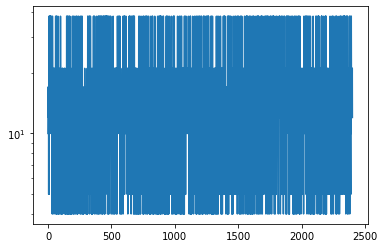

In [32]:
plt.semilogy(feat_tr[:,-1])

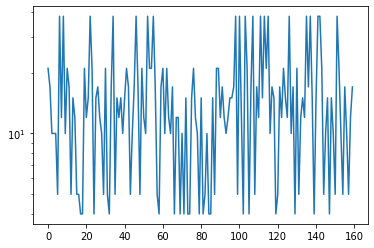

In [33]:
plt.semilogy(feat_test[:,-1])

### To obtain set of one hot codes for our labels

In [34]:
feat_test[:,-1] = [genre_set.index(w) for w in feat_test[:,-1]]
feat_tr[:,-1] = [genre_set.index(w) for w in feat_tr[:,-1]]

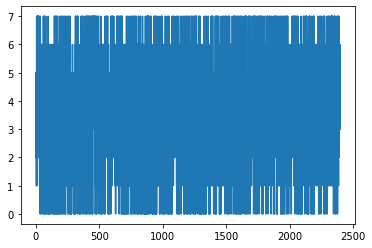

In [35]:
plt.plot(feat_tr[:,-1])

In [36]:
num_classes = len(genre_set)
one_hot = np.zeros((num_classes, num_classes*tr_len))
print(one_hot.shape)
for index_i, i in enumerate(feat_tr[:,-1]):
    one_hot[int(i),index_i] = 1


(8, 2400)


In [37]:
feat_tr[0:10,-1]

array([2, 4, 5, 3, 5, 1, 3, 7, 1, 5], dtype=object)

In [38]:
print(one_hot[:,0:10])
print(one_hot.shape)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]
(8, 2400)


## Training Stage

### Setting up data 

In [39]:
x_train = tr_features/1000
x_test = test_features/1000
y_train = feat_tr[:,-1]
y_test = feat_test[:,-1]

In [40]:
class_set = list(range(num_classes))
class_lbl = [genre_set[i] for i in class_set]
class_name = [main_label_dict[genre_set[i]] for i in class_set]
label_dict = dict(zip(class_name,class_set))

In [41]:
label_dict

{'Jazz': 0,
 'Classical': 1,
 'Pop': 2,
 'Rock': 3,
 'Electronic': 4,
 'Folk': 5,
 'Hip-Hop': 6,
 'Experimental': 7}

In [42]:
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    #plt.figure(figsize=(8,8))
    plt.subplots()
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    
    ax = plt.gca();

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.gcf().subplots_adjust(bottom=0.15)
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels1 = np.zeros((num_records, num_classes))
    #print(true_labels.shape)
    for index_i, i in enumerate(true_labels):
        #print(index_i,i)
        true_labels1[index_i,int(i)] = 1
    return true_labels1

def display_results(y_test, pred_probs, cm = True):
    pred = np.argmax(pred_probs, axis=-1)
    #print(pred)
    one_hot_true = one_hot_encoder(y_test, len(pred), num_classes)
    print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.2f}'.format(f1_score(y_test, pred, average='macro')))
    print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=label_dict.keys())

### Boosting

In [43]:
%%time
# Train

xgb_classifier = xgb.XGBClassifier(max_depth=5, learning_rate=0.01, objective='multi:hardprob', \
                                   n_estimators=700, sub_sample = 0.9, num_class = num_classes)
xgb_classifier.fit(x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(x_test)


NameError: name 'xgb' is not defined

In [44]:
pred = np.argmax(pred_probs, axis=-1)
print('Test Error: ',len(y_test[y_test!=pred])/len(y_test))

NameError: name 'pred_probs' is not defined

In [45]:
display_results(np.array(y_test,dtype=int), pred_probs)

NameError: name 'pred_probs' is not defined

### SVM 

##### Before changes were made:
Test Set Accuracy =  0.26
Test Set F-score =  0.25
ROC AUC = 0.642
Confusion matrix, without normalization
[[ 4  2  3  4  1  3  0  3]
 [ 0 20  0  0  0  0  0  0]
 [ 3  0  4 11  0  1  1  0]
 [ 6  1  2  5  0  1  5  0]
 [ 2  1  1  8  1  3  1  3]
 [ 5  1  0  2  1  0  8  3]
 [ 1  0  0  3  0  9  4  3]
 [ 1  0  1  4  1  1  8  4]]
 

##### After removing rock


Test Set Accuracy =  0.31
Test Set F-score =  0.30
ROC AUC = 0.658
Confusion matrix, without normalization
[[ 7  0  4  4  2  1  2]
 [ 0 20  0  0  0  0  0]
 [ 5  0  4  2  4  5  0]
 [ 1  1  9  2  1  2  4]
 [ 5  1  2  2  1  4  5]
 [ 1  0  0  1  9  5  4]
 [ 1  2  2  3  1  6  5]]
 
 
##### After removing jazz

Test Set Accuracy =  0.33
Test Set F-score =  0.28
ROC AUC = 0.713
Confusion matrix, without normalization
[[ 6  4  0  6  1  1  2]
 [ 1 14  0  2  2  1  0]
 [12  2  0  5  0  0  1]
 [ 1  1  1 15  0  0  2]
 [ 1  2  3  7  0  4  3]
 [ 0  0  1  8  2  5  4]
 [ 2  0  0  6  1  5  6]]

In [46]:
cl_weight = dict(pd.Series(np.array(y_train,dtype=int)).value_counts(normalize=True))

In [47]:
cl_weight

{7: 0.125,
 5: 0.125,
 3: 0.125,
 1: 0.125,
 6: 0.125,
 4: 0.125,
 2: 0.125,
 0: 0.125}

In [48]:
%%time

# Train
svm_classifier = SVC(C=10000.0, kernel = 'rbf', probability = True, class_weight=cl_weight)
svm_classifier.fit(x_train, np.array(y_train,dtype=int))

# Predict
pred_probs = svm_classifier.predict_proba(x_test)

E:\Anaconda\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Wall time: 2.04 s


In [49]:
pred = np.argmax(pred_probs, axis=-1)
print('Test Error: ',len(y_test[y_test!=pred])/len(y_test))

Test Error:  0.75


Test Set Accuracy =  0.25
Test Set F-score =  0.24
ROC AUC = 0.641
Confusion matrix, without normalization
[[ 4  2  3  4  2  4  0  1]
 [ 0 20  0  0  0  0  0  0]
 [ 4  0  3 11  0  1  1  0]
 [ 6  1  2  4  0  2  5  0]
 [ 1  1  1  8  1  4  1  3]
 [ 5  1  0  2  1  0  8  3]
 [ 1  0  0  3  0  9  4  3]
 [ 1  0  1  4  1  1  8  4]]


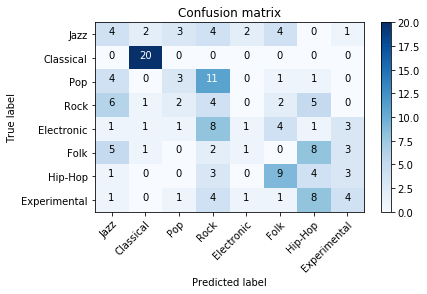

In [50]:
display_results(np.array(y_test,dtype=int), pred_probs)

### Random Forest

In [51]:
%%time
# Train
rf_classifier = RandomForestClassifier(n_estimators=500, min_samples_split=5)
rf_classifier.fit(x_train, np.array(y_train,dtype=int))

# Predict
pred_probs = rf_classifier.predict_proba(x_test)

Wall time: 4.36 s


Test Set Accuracy =  0.30
Test Set F-score =  0.30
ROC AUC = 0.678
Confusion matrix, without normalization
[[ 6  1  2  4  2  2  1  2]
 [ 0 20  0  0  0  0  0  0]
 [ 2  0  6  8  3  0  1  0]
 [ 4  0  1  3  4  3  3  2]
 [ 4  0  0  8  1  2  3  2]
 [ 3  0  0  2  3  4  3  5]
 [ 0  0  0  1  3  5  6  5]
 [ 1  2  1  4  3  4  3  2]]


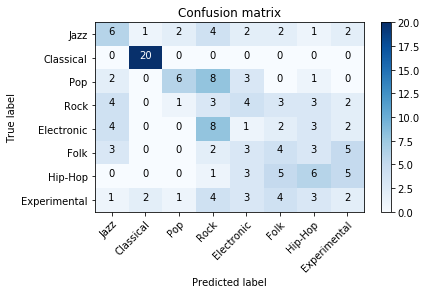

In [52]:
# Results
display_results(np.array(y_test,dtype=int), pred_probs)

### Logistic Regression

In [53]:
%%time
# Train
lr_classifier = LogisticRegression(penalty='l2')
lr_classifier.fit(x_train, np.array(y_train,dtype=int))

# Predict
pred_probs = lr_classifier.predict_proba(x_test)

Wall time: 75.8 ms


E:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
E:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Test Set Accuracy =  0.23
Test Set F-score =  0.17
ROC AUC = 0.558
Confusion matrix, without normalization
[[ 5  3  0  7  0  1  1  3]
 [ 0 20  0  0  0  0  0  0]
 [ 1  0  0 17  0  1  0  1]
 [ 3 10  0  6  0  1  0  0]
 [ 2  3  0 13  0  1  0  1]
 [ 0  8  1  7  0  2  2  0]
 [ 2  4  0 10  0  1  0  3]
 [ 3  3  0  8  0  0  2  4]]


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


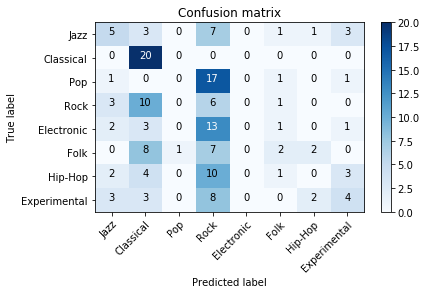

In [54]:
# Results
display_results(np.array(y_test,dtype=int), pred_probs)

### Neural Network

In [55]:
from torch import nn

In [56]:
import torch

In [155]:
x_train = x_train.T
x_train.shape

(2400, 19)

In [58]:
x_test = x_test.T
x_test.shape

(19, 160)

In [59]:
y_train.shape

(2400,)

In [60]:
y_train = y_train.T
y_train.shape

(2400,)

In [61]:
def label2onehot(lbl):
    d = np.zeros((lbl.max() + 1, lbl.size))
    d[lbl, np.arange(lbl.size)] = 1
    return d

In [62]:
def onehot2label(d):
    lbl = d.argmax(axis=0)
    return lbl

In [63]:
# turn labels into one hot
y_train.shape
print(type(y_train))
y_train = y_train.astype(int)
y_train_onehot = label2onehot(y_train)

<class 'numpy.ndarray'>


In [143]:
def init_shallow(Ni, Nh, No):
    b1 = np.random.randn(Nh, 1) / np.sqrt((Ni+1.)/2.)
    W1 = np.random.randn(Nh, Ni) / np.sqrt((Ni+1.)/2.)
    b2 = np.random.randn(No, 1) / np.sqrt((Nh+1.))
    W2 = np.random.randn(No, Nh) / np.sqrt((Nh+1.))
    return W1, b1, W2, b2
Ni = x_train.shape[0]
Nh = 150
No = y_train_onehot.shape[0]
netinit = init_shallow(Ni, Nh, No)

In [144]:
print(y_train_onehot)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [145]:
def softmax(a):
    a_max = np.zeros((1,60000))
    a_max = a.max(axis = 0)
    a_sane = a - a_max
    a_sane_exp = np.exp(a_sane)
    y = a_sane_exp/(a_sane_exp.sum(axis = 0))
    return y

In [146]:
def softmaxp(a,e):
    k = softmax(a)
    part1 = np.multiply(k,e)
    new = part1.sum(axis = 0)
    part2 = np.multiply(new.T,k)
    return(part1 - part2)

In [147]:
def relu(a):
    return(np.where(a>0,a,0))

In [148]:
def relup(a,e):
    a = np.where(a>0,1,0)
    return(a*e)

In [149]:
def forwardprop_shallow(x, net):
#     print(net)
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
#     print("Shape of W1 is ", W1.shape)
#     print(x.shape)
    Z1 = W1.dot(x) + b1
    a1 = relu(Z1)
    a2 = W2.dot(a1) + b2
    y = softmax(a2)
    return y
yinit = forwardprop_shallow(x_train, netinit)

In [150]:
def eval_loss(y, d):
    sum_vert = -np.log(y)*d
    return(sum_vert.sum()/y.shape[1])
print(eval_loss(yinit, y_train_onehot), 'should be around .26')

2.0999037498382553 should be around .26


In [151]:
def eval_perfs(y, lbl):
    y_oneD = onehot2label(y)
    perf_par = (y_oneD != lbl)
    sum_perf_par = perf_par.sum()
    return (sum_perf_par/lbl.shape[0])*100
print(eval_perfs(yinit, y_train))

89.04166666666666


In [152]:
def update_shallow(x, d, net, gamma=.05):
    W1 = net[0]
    b1 = net[1]
    W2 = net[2]
    b2 = net[3]
    Ni = W1.shape[1]
    Nh = W1.shape[0]
    No = W2.shape[0]
    gamma = gamma / x.shape[1] # normalized by the training dataset size
    Z1 = W1.dot(x) + b1
    a1 = relu(Z1)
    a2 = W2.dot(a1) + b2
    y = softmax(a2)
    e2 = - d / y
    delta2 = softmaxp(a2,e2)
    e1 = W2.T.dot(delta2)
    delta1 = relup(a1, e1) 
    W2 = W2 - gamma * delta2.dot(a1.T)
    W1 = W1 - gamma * delta1.dot(x.T)
    b2 = b2 - gamma * delta2.sum(axis =1, keepdims = True )
    b1 = b1 - gamma * delta1.sum(axis =1, keepdims = True )
    return W1, b1, W2, b2

In [153]:
def backprop_shallow(x, d, net, T, gamma=.05):
    lbl = onehot2label(d)
    for t in range(T):
        net = update_shallow(x, d, net)
        #net = [W1,b1,W2,b2]
        y = forwardprop_shallow(x, net)
        loss = eval_loss(y, d)
        print(loss)
        performance = eval_perfs(y, lbl)
        print(performance)
    return net

In [154]:
nettrain_batch2 = backprop_shallow(x_train, y_train_onehot, netinit, 10000)

2.0972426823978934
89.45833333333333
2.0949524454141004
89.45833333333333
2.092980457476035
89.58333333333334
2.0912813318394203
89.45833333333333
2.0898162820784765
89.16666666666667
2.0885519557820427
89.25
2.087459333933429
89.08333333333334
2.086513626776874
89.125
2.0856935173930395
89.125
2.0849808580917877
88.91666666666667
2.084360223019993
88.875
2.083818133734967
88.75
2.0833431875640374
88.54166666666666
2.082925487632331
88.33333333333333
2.0825565469964546
88.25
2.0822292511944696
88.0
2.081937388524283
88.08333333333334
2.0816759956276663
87.75
2.0814405996422023
87.54166666666666
2.0812271864909953
87.66666666666667
2.0810324683015193
87.58333333333333
2.0808534613565044
87.375
2.0806878109674987
87.25
2.0805336027681407
87.0
2.080389197073774
87.04166666666666
2.080252944689847
86.91666666666666
2.0801236934243263
86.58333333333333
2.080000346628179
86.375
2.0798819449498582
86.20833333333333
2.0797678752023927
86.29166666666667
2.0796576130147373
85.95833333333334
2.07

2.0485599259183527
79.5
2.0485045238989943
79.5
2.0484491431808163
79.5
2.048393781243746
79.45833333333333
2.0483384629122128
79.45833333333333
2.0482831890995814
79.41666666666667
2.0482279399824264
79.41666666666667
2.0481727492873265
79.41666666666667
2.0481175943786125
79.41666666666667
2.048062460543667
79.41666666666667
2.04800735329872
79.41666666666667
2.047952307808955
79.41666666666667
2.0478973015522395
79.41666666666667
2.0478423477444756
79.41666666666667
2.0477874271064205
79.41666666666667
2.0477325478747685
79.41666666666667
2.047677722646233
79.41666666666667
2.047622928141508
79.41666666666667
2.0475681696154746
79.41666666666667
2.047513430042855
79.41666666666667
2.047458712763329
79.41666666666667
2.047404005323067
79.41666666666667
2.0473493159202016
79.41666666666667
2.0472946417275444
79.41666666666667
2.047239988417541
79.41666666666667
2.047185394347134
79.41666666666667
2.047130825972615
79.375
2.0470762913098755
79.375
2.0470217790193526
79.375
2.0469672807

2.024972256953014
78.66666666666666
2.024932882611372
78.66666666666666
2.0248935531109065
78.66666666666666
2.0248542761346426
78.66666666666666
2.024815044754132
78.625
2.0247758317448694
78.66666666666666
2.0247366424932633
78.66666666666666
2.0246974909575743
78.66666666666666
2.024658396371483
78.66666666666666
2.02461932472088
78.66666666666666
2.0245802873104903
78.66666666666666
2.024541269933343
78.66666666666666
2.024502280482528
78.66666666666666
2.0244633438081534
78.66666666666666
2.024424449709737
78.66666666666666
2.024385574955153
78.66666666666666
2.024346692868676
78.66666666666666
2.0243078252043447
78.66666666666666
2.0242689789411417
78.66666666666666
2.0242301765788713
78.66666666666666
2.02419139075309
78.66666666666666
2.024152648794846
78.66666666666666
2.0241139352635322
78.66666666666666
2.0240752458601565
78.66666666666666
2.0240365642308658
78.66666666666666
2.0239978761147257
78.66666666666666
2.023959207061652
78.66666666666666
2.0239205812450027
78.625
2

2.00954321552953
78.66666666666666
2.00952046801992
78.66666666666666
2.009497750989376
78.66666666666666
2.009475063065652
78.66666666666666
2.00945240341249
78.66666666666666
2.0094297714919414
78.66666666666666
2.009407168197961
78.66666666666666
2.009384591032898
78.66666666666666
2.0093620423061123
78.66666666666666
2.009339526227167
78.66666666666666
2.0093170418160216
78.66666666666666
2.009294575881225
78.66666666666666
2.0092721405915936
78.66666666666666
2.009249726788705
78.66666666666666
2.0092273441919586
78.625
2.0092049899176687
78.625
2.009182660621036
78.625
2.0091603601876113
78.625
2.009138098171414
78.625
2.0091158661414443
78.625
2.0090936688048826
78.66666666666666
2.009071506334516
78.66666666666666
2.0090493674776195
78.66666666666666
2.009027250765541
78.66666666666666
2.009005159909801
78.66666666666666
2.0089830937954183
78.66666666666666
2.0089610514282272
78.70833333333334
2.0089390356207164
78.70833333333334
2.0089170525960176
78.70833333333334
2.008895095

2.0012213661608005
78.375
2.001208435564193
78.375
2.001195522840079
78.375
2.001182623674641
78.375
2.0011697413753913
78.375
2.0011568741642902
78.375
2.0011440223295613
78.375
2.001131188678043
78.375
2.001118369620616
78.375
2.001105566524846
78.375
2.0010927791619415
78.375
2.0010800067038588
78.375
2.0010672466320445
78.375
2.0010545030987736
78.375
2.001041775246659
78.375
2.001029064176502
78.375
2.001016353789609
78.375
2.0010036549453627
78.375
2.0009909690499295
78.375
2.0009782997322
78.375
2.0009656446909876
78.375
2.0009530039346815
78.375
2.000940375632834
78.375
2.000927764918498
78.375
2.0009151681580284
78.375
2.0009025815942207
78.375
2.0008900051115663
78.375
2.0008774421958764
78.375
2.0008649001344883
78.375
2.000852373372602
78.375
2.0008398605564643
78.375
2.0008273640997345
78.375
2.000814880363488
78.375
2.000802410168701
78.375
2.0007899561491382
78.375
2.0007775181683343
78.375
2.0007650969911315
78.375
2.0007526944817884
78.375
2.000740307131116
78.375
2.00

1.996029603573877
78.16666666666666
1.9960217151517774
78.16666666666666
1.9960138318709517
78.16666666666666
1.996005953983131
78.16666666666666
1.995998081977112
78.16666666666666
1.9959902152505817
78.16666666666666
1.9959823541721615
78.16666666666666
1.9959745004406648
78.16666666666666
1.9959666546860637
78.16666666666666
1.9959588154676293
78.16666666666666
1.9959509811131377
78.16666666666666
1.995943159447745
78.16666666666666
1.9959353453642494
78.16666666666666
1.9959275433137589
78.16666666666666
1.9959197450958739
78.16666666666666
1.9959119513497035
78.16666666666666
1.9959041632094363
78.16666666666666
1.995896383966019
78.16666666666666
1.995888612516418
78.16666666666666
1.9958808526491605
78.16666666666666
1.9958730978269652
78.16666666666666
1.9958653482854924
78.16666666666666
1.9958576031232307
78.16666666666666
1.9958498624504124
78.16666666666666
1.9958421262107489
78.16666666666666
1.9958343935661673
78.16666666666666
1.9958266680233505
78.16666666666666
1.99581

1.9928379046427256
77.79166666666667
1.9928319360830187
77.79166666666667
1.99282596978959
77.79166666666667
1.9928200055843612
77.79166666666667
1.9928140437007684
77.79166666666667
1.992808083569148
77.79166666666667
1.9928021245323315
77.79166666666667
1.9927961672060708
77.79166666666667
1.9927902146375922
77.79166666666667
1.992784265679216
77.79166666666667
1.9927783195608162
77.79166666666667
1.9927723761077034
77.79166666666667
1.992766435340834
77.79166666666667
1.992760497830283
77.79166666666667
1.9927545615798272
77.79166666666667
1.9927486263306495
77.79166666666667
1.9927426979854364
77.79166666666667
1.9927367685938184
77.79166666666667
1.992730838844182
77.83333333333333
1.9927249084780025
77.83333333333333
1.9927189764309483
77.83333333333333
1.9927130472260577
77.83333333333333
1.9927071176891187
77.83333333333333
1.9927011895879396
77.83333333333333
1.9926952623087246
77.83333333333333
1.9926893372011993
77.83333333333333
1.9926834154985436
77.83333333333333
1.992677

1.990311177970115
77.70833333333333
1.9903059773998333
77.70833333333333
1.9903007756425761
77.70833333333333
1.9902955735672898
77.70833333333333
1.9902903705853745
77.70833333333333
1.9902851682167702
77.70833333333333
1.99027996597408
77.70833333333333
1.9902747628257975
77.70833333333333
1.9902695601269993
77.70833333333333
1.990264358641731
77.70833333333333
1.9902591572380197
77.70833333333333
1.9902539526086291
77.70833333333333
1.990248748002898
77.70833333333333
1.9902435405768373
77.70833333333333
1.990238334317456
77.70833333333333
1.9902331305060164
77.70833333333333
1.9902279310926656
77.70833333333333
1.9902227341696281
77.70833333333333
1.9902175359681624
77.70833333333333
1.9902123385327017
77.70833333333333
1.9902071379450077
77.70833333333333
1.9902019411629543
77.70833333333333
1.9901967426999871
77.70833333333333
1.9901915423505014
77.70833333333333
1.9901863414721424
77.70833333333333
1.9901811388500903
77.70833333333333
1.9901759368821812
77.70833333333333
1.99017

1.9878981547803103
77.5
1.987893220340139
77.5
1.9878882789470276
77.5
1.987883339623481
77.5
1.9878784034855406
77.5
1.9878734672288518
77.5
1.9878685261067308
77.5
1.9878635908505544
77.5
1.987858662910567
77.5
1.9878537441863124
77.5
1.9878488303900888
77.5
1.9878439244283224
77.5
1.9878390347597925
77.45833333333333
1.9878341487130167
77.45833333333333
1.987829259322904
77.45833333333333
1.9878243648357148
77.45833333333333
1.9878194777118252
77.45833333333333
1.987814593875415
77.45833333333333
1.9878097116336202
77.45833333333333
1.9878048312606487
77.45833333333333
1.9877999527195382
77.45833333333333
1.9877950756548064
77.45833333333333
1.9877902046974243
77.45833333333333
1.9877853374009018
77.45833333333333
1.9877804686386669
77.45833333333333
1.9877755994325548
77.45833333333333
1.987770733819239
77.45833333333333
1.9877658732259889
77.45833333333333
1.9877610136120905
77.45833333333333
1.9877561540347344
77.45833333333333
1.987751295370033
77.45833333333333
1.98774643577575

1.9855921832210803
77.33333333333333
1.9855874784785048
77.33333333333333
1.9855827739997642
77.29166666666667
1.985578069798521
77.29166666666667
1.9855733654134187
77.29166666666667
1.9855686600558382
77.29166666666667
1.9855639546710382
77.29166666666667
1.985559249404768
77.29166666666667
1.9855545445722418
77.29166666666667
1.9855498397308102
77.29166666666667
1.9855451351220488
77.29166666666667
1.9855404307846947
77.29166666666667
1.9855357262963693
77.29166666666667
1.9855310218889206
77.29166666666667
1.9855263176748599
77.29166666666667
1.985521612302597
77.29166666666667
1.985516904570934
77.29166666666667
1.985512196667333
77.29166666666667
1.9855074889418303
77.29166666666667
1.985502781284251
77.29166666666667
1.9854980736068009
77.29166666666667
1.9854933658698177
77.29166666666667
1.9854886583339537
77.29166666666667
1.9854839508823163
77.29166666666667
1.985479243988824
77.29166666666667
1.9854745396848223
77.25
1.9854698364896937
77.25
1.9854651316899186
77.25
1.98546

1.9831311951903832
76.95833333333333
1.9831265325370588
76.95833333333333
1.9831218696047521
76.95833333333333
1.9831172086850655
76.95833333333333
1.9831125480800214
76.95833333333333
1.9831078870271472
76.95833333333333
1.9831032266334079
76.95833333333333
1.9830985657084508
76.95833333333333
1.9830939056004073
76.95833333333333
1.9830892449983402
76.95833333333333
1.9830845848119247
76.95833333333333
1.983079924720674
76.95833333333333
1.9830752646871785
76.95833333333333
1.9830706047990199
76.95833333333333
1.983065944626412
76.95833333333333
1.9830612838662494
76.95833333333333
1.983056623234329
76.95833333333333
1.983051962870238
76.95833333333333
1.9830473025969007
76.95833333333333
1.9830426423437537
76.95833333333333
1.9830379823966715
76.95833333333333
1.9830333225441996
76.95833333333333
1.98302866271202
76.95833333333333
1.9830240031524349
76.95833333333333
1.9830193434084002
76.95833333333333
1.9830146839622096
76.95833333333333
1.9830100246331108
76.95833333333333
1.98300

1.9808890537803154
76.91666666666667
1.9808843928881652
76.91666666666667
1.9808797369740985
76.91666666666667
1.9808750766591758
76.91666666666667
1.9808704126821628
76.91666666666667
1.980865753093589
76.91666666666667
1.980861093812698
76.91666666666667
1.9808564344086457
76.91666666666667
1.9808517730594901
76.91666666666667
1.9808471063538653
76.91666666666667
1.9808424309505126
76.91666666666667
1.9808377529169146
76.91666666666667
1.9808330723856682
76.91666666666667
1.9808283988036344
76.91666666666667
1.9808237252460423
76.91666666666667
1.9808190494122528
76.91666666666667
1.9808143698380969
76.91666666666667
1.9808096905589412
76.91666666666667
1.980805011669562
76.91666666666667
1.980800332844395
76.91666666666667
1.9807956543294734
76.91666666666667
1.9807909757915574
76.91666666666667
1.9807863001040347
76.91666666666667
1.980781630998372
76.91666666666667
1.98077696866933
76.91666666666667
1.9807723060752103
76.91666666666667
1.9807676437534352
76.91666666666667
1.980762

76.54166666666666
1.9784651283727968
76.54166666666666
1.978460482184596
76.54166666666666
1.978455834851075
76.54166666666666
1.9784511860025853
76.54166666666666
1.9784465343052424
76.54166666666666
1.978441883523873
76.54166666666666
1.9784372365523897
76.54166666666666
1.9784325894902626
76.54166666666666
1.9784279405782035
76.54166666666666
1.9784232918904607
76.5
1.9784186413767293
76.5
1.9784139906006988
76.5
1.9784093402869243
76.5
1.978404691035591
76.5
1.9784000410424178
76.5
1.9783953892264803
76.5
1.9783907373437986
76.5
1.9783860851358823
76.5
1.9783814341130967
76.5
1.978376785722534
76.5
1.9783721391269402
76.5
1.9783674927064363
76.5
1.9783628467442915
76.5
1.9783582019292028
76.5
1.978353556774041
76.5
1.9783489119475572
76.5
1.9783442673763405
76.5
1.9783396259611057
76.5
1.9783349857774537
76.5
1.9783303468693907
76.5
1.978325708062188
76.5
1.9783210697926563
76.5
1.9783164308516636
76.5
1.9783117915000894
76.5
1.9783071515569213
76.5
1.9783025121040183
76.5
1.978297

1.9761046005823133
76.33333333333333
1.976099976623398
76.33333333333333
1.9760953529128793
76.33333333333333
1.9760907288102636
76.33333333333333
1.9760861056559573
76.33333333333333
1.976081482937173
76.33333333333333
1.9760768606575667
76.33333333333333
1.9760722383610034
76.33333333333333
1.9760676160878377
76.33333333333333
1.9760629940167276
76.33333333333333
1.9760583716162479
76.33333333333333
1.9760537491660692
76.33333333333333
1.976049127211368
76.33333333333333
1.9760445048744653
76.33333333333333
1.9760398831259534
76.33333333333333
1.9760352606388059
76.33333333333333
1.9760306391828153
76.33333333333333
1.9760260170076067
76.33333333333333
1.9760213956925394
76.33333333333333
1.976016773569208
76.33333333333333
1.9760121508406798
76.33333333333333
1.9760075279057427
76.33333333333333
1.976002904744164
76.33333333333333
1.9759982818401962
76.33333333333333
1.9759936586887723
76.33333333333333
1.9759890359792374
76.33333333333333
1.9759844129463349
76.29166666666667
1.9759

1.9737070062936362
75.83333333333333
1.9737024130887437
75.83333333333333
1.9736978203782398
75.83333333333333
1.9736932273268917
75.83333333333333
1.9736886342687892
75.83333333333333
1.973684041644239
75.83333333333333
1.973679448920404
75.83333333333333
1.9736748560398722
75.83333333333333
1.973670263572074
75.83333333333333
1.973665671174578
75.83333333333333
1.9736610786326525
75.83333333333333
1.9736564861754111
75.83333333333333
1.9736518941256913
75.83333333333333
1.9736473017207008
75.83333333333333
1.9736427094665039
75.83333333333333
1.9736381175701316
75.83333333333333
1.9736335254983062
75.83333333333333
1.973628933466318
75.83333333333333
1.973624341448984
75.83333333333333
1.9736197494608176
75.83333333333333
1.9736151575234722
75.83333333333333
1.9736105657998935
75.83333333333333
1.973605974100357
75.83333333333333
1.9736013823721275
75.83333333333333
1.973596790795536
75.83333333333333
1.973592199346546
75.83333333333333
1.9735876078877213
75.83333333333333
1.97358301

75.83333333333333
1.9715220925429826
75.83333333333333
1.9715175324560767
75.83333333333333
1.9715129719506028
75.83333333333333
1.9715084119611566
75.83333333333333
1.9715038515759709
75.83333333333333
1.9714992916715994
75.83333333333333
1.9714947316570375
75.83333333333333
1.9714901716581679
75.83333333333333
1.9714856117848816
75.83333333333333
1.9714810516995616
75.83333333333333
1.9714764920281558
75.83333333333333
1.971471932708805
75.83333333333333
1.9714673741439386
75.83333333333333
1.971462812632711
75.83333333333333
1.971458250664206
75.83333333333333
1.9714536836399983
75.83333333333333
1.9714491171257122
75.83333333333333
1.9714445502089386
75.83333333333333
1.971439983676091
75.83333333333333
1.9714354171188737
75.83333333333333
1.971430849759516
75.83333333333333
1.9714262810296608
75.83333333333333
1.9714217111722412
75.83333333333333
1.9714171402052867
75.83333333333333
1.971412568792367
75.83333333333333
1.9714079980403316
75.83333333333333
1.9714034266266114
75.8333

75.875
1.96925967334757
75.875
1.9692551568617689
75.875
1.9692506400252667
75.875
1.9692461234038778
75.91666666666667
1.969241606886526
75.91666666666667
1.9692370901891891
75.91666666666667
1.9692325741039913
75.91666666666667
1.9692280576061945
75.91666666666667
1.969223541038481
75.91666666666667
1.969219025095757
75.91666666666667
1.9692145085871986
75.91666666666667
1.9692099888934878
75.91666666666667
1.969205468101873
75.91666666666667
1.9692009474146228
75.875
1.9691964292607187
75.875
1.9691919121022368
75.875
1.9691873950304213
75.875
1.9691828782812872
75.875
1.9691783610944404
75.875
1.969173844017518
75.875
1.9691693273710158
75.875
1.9691648103492947
75.875
1.9691602934140457
75.875
1.969155776839184
75.875
1.9691512598435326
75.875
1.9691467433289154
75.875
1.9691422268481047
75.875
1.969137710148444
75.875
1.9691331939606547
75.875
1.9691286773036867
75.875
1.9691241609421373
75.875
1.969119644890675
75.91666666666667
1.9691151285869632
75.91666666666667
1.96911061239

1.9671178686525113
75.70833333333333
1.9671134026719592
75.70833333333333
1.967108937654882
75.70833333333333
1.9671044739467947
75.70833333333333
1.9671000092280473
75.70833333333333
1.9670955442050273
75.70833333333333
1.967091081369077
75.70833333333333
1.9670866201571402
75.70833333333333
1.9670821591976453
75.70833333333333
1.9670776986723448
75.70833333333333
1.9670732380161435
75.70833333333333
1.967068777574251
75.70833333333333
1.96706431767195
75.70833333333333
1.9670598572357993
75.70833333333333
1.9670553975077985
75.75
1.9670509376396255
75.75
1.9670464777532262
75.66666666666667
1.9670420188979316
75.66666666666667
1.9670375595947647
75.66666666666667
1.9670331001432753
75.66666666666667
1.9670286397743981
75.66666666666667
1.9670241791143241
75.625
1.9670197188282275
75.625
1.9670152591034211
75.625
1.967010797161034
75.625
1.9670063361631245
75.625
1.9670018761598396
75.625
1.966997416973618
75.625
1.966992961446105
75.625
1.966988505832137
75.625
1.966984050020117
75.6

1.9649188920697165
75.54166666666666
1.9649145079772454
75.54166666666666
1.9649101230673662
75.54166666666666
1.9649057388406452
75.54166666666666
1.964901354669687
75.54166666666666
1.9648969705323127
75.54166666666666
1.9648925868244405
75.54166666666666
1.9648882029770243
75.54166666666666
1.9648838195232108
75.54166666666666
1.9648794359922446
75.54166666666666
1.9648750525882581
75.54166666666666
1.9648706698392493
75.54166666666666
1.964866287696248
75.54166666666666
1.9648619044763862
75.54166666666666
1.9648575220434779
75.58333333333334
1.9648531404884702
75.58333333333334
1.964848757774449
75.58333333333334
1.9648443748263136
75.58333333333334
1.9648399919308845
75.58333333333334
1.9648356095714863
75.58333333333334
1.9648312273970092
75.58333333333334
1.9648268448795476
75.58333333333334
1.964822462911853
75.58333333333334
1.9648180812383251
75.58333333333334
1.9648136994676932
75.58333333333334
1.9648093175598138
75.58333333333334
1.9648049363843976
75.58333333333334
1.964

1.9626488753657407
75.5
1.962644560107832
75.5
1.962640244215846
75.5
1.9626359294375322
75.5
1.9626316143841545
75.5
1.9626272992493008
75.5
1.9626229847826289
75.5
1.962618669996811
75.5
1.962614355770824
75.5
1.962610041505078
75.5
1.96260572795173
75.5
1.9626014141687878
75.5
1.9625971028911426
75.5
1.9625927895843556
75.5
1.9625884769905384
75.5
1.9625841653604346
75.5
1.9625798525556046
75.5
1.9625755373513252
75.5
1.9625712134248252
75.5
1.962566889402469
75.5
1.9625625651688594
75.5
1.9625582434144242
75.5
1.9625539188145407
75.5
1.9625495962811608
75.5
1.9625452721633154
75.5
1.9625409493005341
75.5
1.9625366266970632
75.5
1.9625323040048768
75.5
1.962527981549894
75.5
1.9625236593203843
75.5
1.9625193375493606
75.5
1.9625150153569912
75.5
1.9625106940982942
75.5
1.9625063721588352
75.5
1.9625020513554041
75.5
1.962497729611625
75.5
1.9624934091558335
75.5
1.9624890877056445
75.5
1.9624847674326438
75.5
1.9624804466284649
75.5
1.9624761185537871
75.5
1.962471774161377
75.5
1.9

75.45833333333334
1.960373462370056
75.45833333333334
1.9603692470076715
75.45833333333334
1.9603650322466069
75.45833333333334
1.9603608178925147
75.45833333333334
1.960356603299352
75.45833333333334
1.9603523889644423
75.45833333333334
1.9603481748633331
75.45833333333334
1.9603439614815754
75.45833333333334
1.960339747476097
75.45833333333334
1.960335533417788
75.5
1.960331319892864
75.5
1.9603271070613224
75.5
1.960322893677225
75.5
1.96031868064528
75.5
1.9603144678905453
75.5
1.9603102555885672
75.5
1.96030604351569
75.5
1.960301831635384
75.5
1.9602976201815105
75.5
1.960293409248696
75.5
1.960289198798636
75.5
1.96028498797469
75.5
1.960280777490344
75.5
1.9602765674710725
75.5
1.9602723582938704
75.5
1.960268148562008
75.5
1.9602639392441918
75.5
1.9602597299634552
75.5
1.9602555216547732
75.5
1.96025131308342
75.5
1.9602471042233716
75.5
1.960242895816348
75.5
1.960238688190824
75.5
1.9602344805061436
75.5
1.960230272578978
75.5
1.9602260650876755
75.5
1.960221857657654
75.5


In [137]:
print(x_test.shape)
print(y_test.shape)

(19, 160)
(160,)


In [156]:
y_test = y_test.astype(int)
y_test_onehot = label2onehot(y_test)

In [161]:
y_output = forwardprop_shallow(x_test, nettrain_batch2)

In [162]:
perf = eval_perfs(y_output, y_test)
print(perf)

78.125


Test Set Accuracy =  0.22


E:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Test Set F-score =  0.18
ROC AUC = 0.570
Confusion matrix, without normalization
[[ 4  2  0  3  0  5  2  4]
 [ 2 18  0  0  0  0  0  0]
 [ 1  0  0 13  0  2  3  1]
 [ 9  2  0  5  0  2  2  0]
 [ 4  1  0 12  0  3  0  0]
 [ 2  5  0  7  0  2  3  1]
 [ 1  3  0  4  0  6  1  5]
 [ 3  2  0  5  0  0  5  5]]


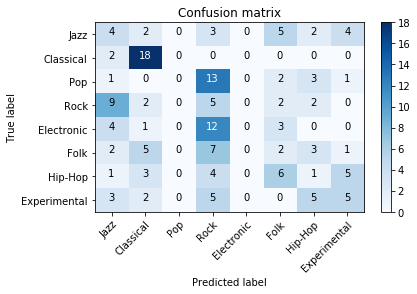

In [159]:
display_results(np.array(y_test,dtype=int), y_output.T)